Az adathalmaz mérete: 433 kép.


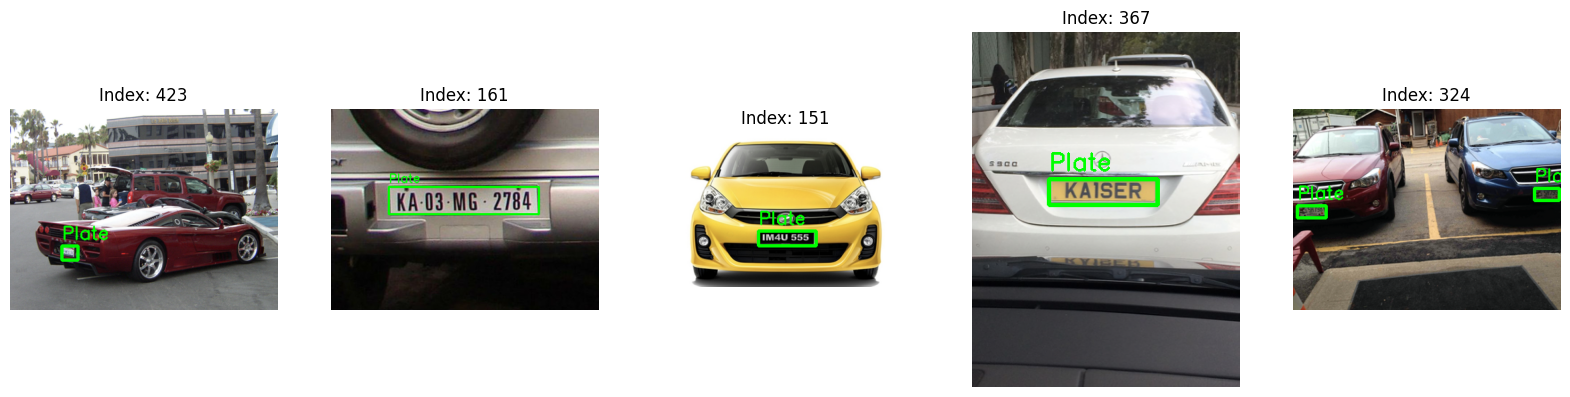

In [1]:
import os
import glob
import cv2
import torch
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset

import torchvision.transforms as T

import torch
import torchvision.transforms as T
import random

class AddGaussianNoise(object):
    """
    Véletlenszerű Gauss-zajt ad a képhez.
    mean: a zaj átlaga
    std: a zaj szórása (minél nagyobb, annál 'hangosabb' a kép)
    """
    def __init__(self, mean=0., std=0.1):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        # Generálunk egy zaj mátrixot
        noise = torch.randn(tensor.size()) * self.std + self.mean
        # Hozzáadjuk a képhez és vágjuk 0-1 közé, hogy érvényes kép maradjon
        return torch.clamp(tensor + noise, 0., 1.)

class RandomBlur(object):
    """
    Véletlenszerűen elhomályosítja a képet (mintha mozogna az autó).
    """
    def __init__(self, p=0.5):
        self.p = p # Valószínűség, hogy alkalmazzuk-e
        self.blur = T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))

    def __call__(self, img):
        if random.random() < self.p:
            return self.blur(img)
        return img

def get_transform(train):
    transforms = []
    # 1. Először Tensorrá alakítjuk (0-1 közötti számok)
    transforms.append(T.ToTensor())
    
    if train:
        # CSAK TANÍTÁSKOR alkalmazzuk ezeket (Train mód)
        
        # A. Színek és Fényerő variálása (Nagyon fontos!)
        # Brightness: sötét/világos képek
        # Contrast: éles/tompa különbségek
        transforms.append(T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1))
        
        # B. Zaj hozzáadása (50% eséllyel)
        # Itt használjuk az imént írt osztályunkat
        # RandomChoice: vagy zajos lesz, vagy nem
        transforms.append(T.RandomApply([AddGaussianNoise(0., 0.05)], p=0.5))
        
        # C. Elmosódás (Blur) - 30% eséllyel
        transforms.append(T.RandomApply([T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0))], p=0.5))

    return T.Compose(transforms)

class CarPlateDataset(Dataset):
    # JAVÍTVA: 'transforms' (többes számban), hogy kompatibilis legyen a hívó kóddal
    def __init__(self, images_dir, annotations_dir, transforms=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transforms = transforms
        
        self.image_files = sorted(glob.glob(os.path.join(images_dir, '*.png')))
        self.valid_images = []
        for img_path in self.image_files:
            base_name = os.path.basename(img_path)
            file_name_no_ext = os.path.splitext(base_name)[0]
            annot_path = os.path.join(self.annotations_dir, file_name_no_ext + '.xml')
            if os.path.exists(annot_path):
                self.valid_images.append(img_path)

    def __len__(self):
        return len(self.valid_images)

    def __getitem__(self, idx):
        img_path = self.valid_images[idx]
        base_name = os.path.basename(img_path)
        file_name_no_ext = os.path.splitext(base_name)[0]
        annot_path = os.path.join(self.annotations_dir, file_name_no_ext + '.xml')
        
        # Kép betöltése
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Annotációk betöltése
        boxes = []
        tree = ET.parse(annot_path)
        root = tree.getroot()
        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        # Transzformáció hívása (itt is 'self.transforms'-ot használunk)
        if self.transforms:
            image = self.transforms(image)

        return image, target
# --- Fő programrész ---

# Útvonalak beállítása (a te specifikációd szerint)
IMG_DIR = '/kaggle/input/car-plate-detection/images'
ANNOT_DIR = '/kaggle/input/car-plate-detection/annotations'

# Adathalmaz példányosítása
dataset = CarPlateDataset(IMG_DIR, ANNOT_DIR)

print(f"Az adathalmaz mérete: {len(dataset)} kép.")

# Vizualizáció: 5 véletlenszerű kép kiválasztása
indices = random.sample(range(len(dataset)), 5)

plt.figure(figsize=(20, 10))

for i, idx in enumerate(indices):
    image, target = dataset[idx]
    
    # Mivel a kép numpy array (vagy tensor), másolatot készítünk a rajzoláshoz
    img_viz = image.copy()
    
    boxes = target["boxes"].numpy()
    
    # Dobozok rárajzolása
    for box in boxes:
        x_min, y_min, x_max, y_max = box.astype(int)
        # Zöld téglalap rajzolása (vastagság: 3)
        cv2.rectangle(img_viz, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)
        cv2.putText(img_viz, "Plate", (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Megjelenítés subplotban
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_viz)
    plt.axis('off')
    plt.title(f"Index: {idx}")

plt.show()

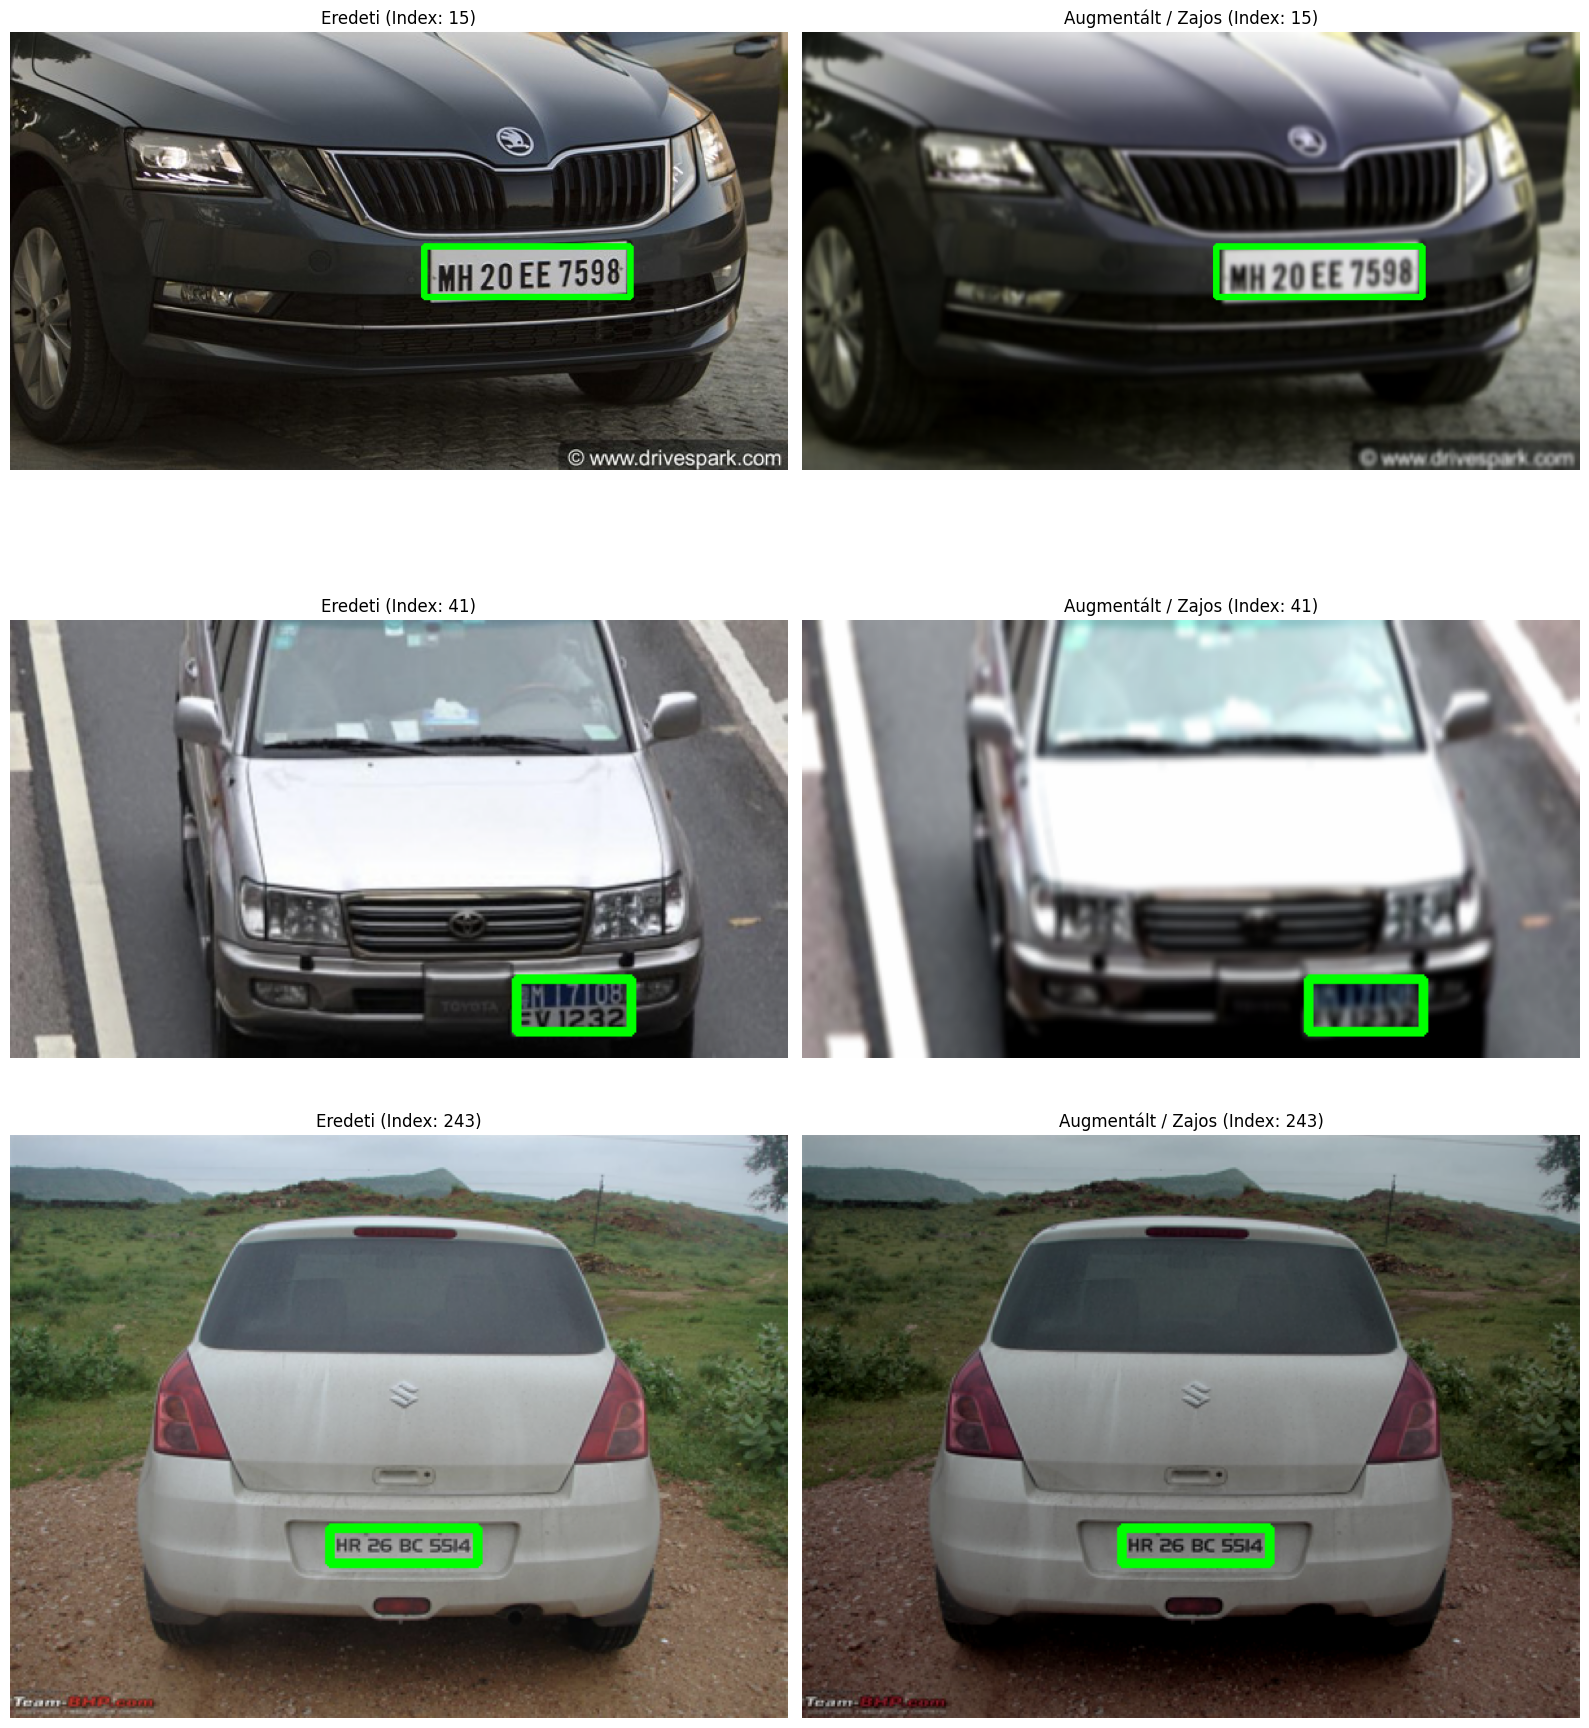

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
import torch

# --- SEGÉDFÜGGVÉNY A MEGJELENÍTÉSHEZ ---
def tensor_to_img_numpy(tensor, target):
    """
    Átalakítja a PyTorch tensort kirajzolható NumPy képpé,
    és rárajzolja a bounding boxokat.
    """
    # 1. Tensor (C, H, W) -> NumPy (H, W, C) és skálázás 0-255 közé
    img_np = tensor.mul(255).permute(1, 2, 0).byte().numpy().copy()
    
    # 2. Dobozok rajzolása
    boxes = target["boxes"].numpy()
    for box in boxes:
        x_min, y_min, x_max, y_max = box.astype(int)
        # Zöld téglalap, vastagság: 3
        cv2.rectangle(img_np, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)
        
    return img_np

# --- 1. KÉT ADATHALMAZ LÉTREHOZÁSA ---

# 'Clean': Nincs zaj, csak alap betöltés (train=False)
dataset_clean = CarPlateDataset(IMG_DIR, ANNOT_DIR, transforms=get_transform(train=False))

# 'Noisy': Van zaj, elmosódás, színtorzítás (train=True)
dataset_noisy = CarPlateDataset(IMG_DIR, ANNOT_DIR, transforms=get_transform(train=True))

# --- 2. PÁROS VIZUALIZÁCIÓ ---

# Válasszunk 3 véletlenszerű képet
num_pairs = 3
indices = random.sample(range(len(dataset_clean)), num_pairs)

plt.figure(figsize=(16, 6 * num_pairs))

for i, idx in enumerate(indices):
    # Lekérjük ugyanazt a képet mindkét datasetből
    img_clean_tensor, target_clean = dataset_clean[idx]
    img_noisy_tensor, target_noisy = dataset_noisy[idx]
    
    # Átalakítás kirajzolható formátumba
    viz_clean = tensor_to_img_numpy(img_clean_tensor, target_clean)
    viz_noisy = tensor_to_img_numpy(img_noisy_tensor, target_noisy)
    
    # --- Eredeti (Bal oldal) ---
    plt.subplot(num_pairs, 2, 2*i + 1)
    plt.imshow(viz_clean)
    plt.title(f"Eredeti (Index: {idx})")
    plt.axis('off')
    
    # --- Zajosított (Jobb oldal) ---
    plt.subplot(num_pairs, 2, 2*i + 2)
    plt.imshow(viz_noisy)
    plt.title(f"Augmentált / Zajos (Index: {idx})")
    plt.axis('off')

plt.tight_layout()
plt.show()

Ugyanaz a kép (10. index) 5 különböző lekéréskor:


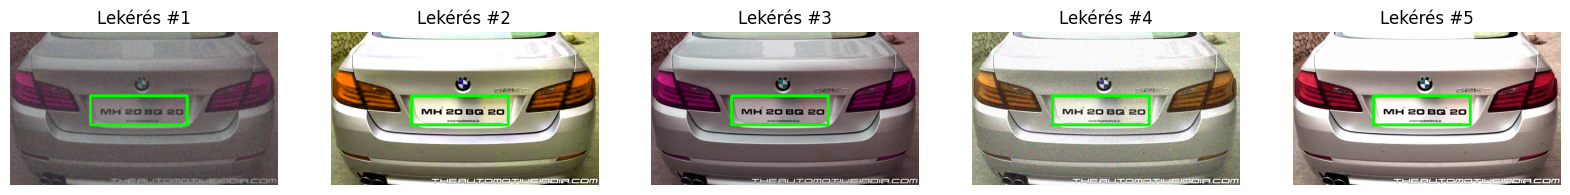

In [3]:
import matplotlib.pyplot as plt
import cv2

# Kiválasztunk EGY fix indexet (pl. a 10. képet)
fix_index = 10 
dataset_aug = CarPlateDataset(IMG_DIR, ANNOT_DIR, transforms=get_transform(train=True))

plt.figure(figsize=(20, 5))

print(f"Ugyanaz a kép ({fix_index}. index) 5 különböző lekéréskor:")

for i in range(5):
    # Ugyanazt az indexet kérjük le újra és újra!
    # A __getitem__ minden híváskor újragenerálja a random zajt.
    img_tensor, target = dataset_aug[fix_index]
    
    img_np = img_tensor.mul(255).permute(1, 2, 0).byte().numpy().copy()
    
    # Doboz rajzolása
    for box in target["boxes"].numpy():
        x_min, y_min, x_max, y_max = box.astype(int)
        cv2.rectangle(img_np, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img_np)
    plt.title(f"Lekérés #{i+1}")
    plt.axis('off')

plt.show()

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_plate_detector_model(num_classes=2):
    """
    Létrehoz egy Faster R-CNN modellt ResNet50 gerinccel (backbone).
    
    Args:
        num_classes (int): Az osztályok száma (beleértve a hátteret is!).
                           Rendszámtábla esetén ez 2 (0: háttér, 1: rendszám).
    """
    
    # 1. Előtanított modell betöltése (COCO súlyokkal)
    # Ez a modell már képes általános tárgyakat felismerni, így gyorsabb a tanítás.
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    
    # 2. A bemeneti jellemzők (features) számának lekérése az osztályozó fejből
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # 3. A modell "fejének" (box predictor) lecserélése
    # Ez felelős a doboz koordináták és az osztály valószínűségének megjósolásáért.
    # Lecseréljük egy újra, ami a mi 'num_classes' számunkhoz igazodik.
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

# --- HASZNÁLAT ---

# Modell példányosítása (2 osztály: 0=háttér, 1=rendszám)
model = get_plate_detector_model(num_classes=2)

# Ha van GPU, mozgatjuk a modellt oda
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

print(f"Modell létrehozva és átmozgatva ide: {device}")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 209MB/s]


Modell létrehozva és átmozgatva ide: cuda


In [5]:
import os
import glob
import torch
import cv2
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset

class CarPlateDataset(Dataset):
    # Itt javítottuk: 'transforms' (többes szám), hogy egyezzen a hívással
    def __init__(self, images_dir, annotations_dir, transforms=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transforms = transforms
        
        self.image_files = sorted(glob.glob(os.path.join(images_dir, '*.png')))
        # Kiszűrjük azokat, amikhez nincs XML (hogy ne legyen hiba)
        self.valid_images = []
        for img_path in self.image_files:
            base_name = os.path.basename(img_path)
            file_name_no_ext = os.path.splitext(base_name)[0]
            annot_path = os.path.join(self.annotations_dir, file_name_no_ext + '.xml')
            if os.path.exists(annot_path):
                self.valid_images.append(img_path)

    def __len__(self):
        return len(self.valid_images)

    def __getitem__(self, idx):
        img_path = self.valid_images[idx]
        base_name = os.path.basename(img_path)
        file_name_no_ext = os.path.splitext(base_name)[0]
        annot_path = os.path.join(self.annotations_dir, file_name_no_ext + '.xml')
        
        # Kép betöltése
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Annotációk betöltése
        boxes = []
        tree = ET.parse(annot_path)
        root = tree.getroot()
        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # Címkék (Labels): Minden dobozhoz 1-es (Rendszám)
        labels = torch.ones((len(boxes),), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        # Transzformáció alkalmazása (itt hívjuk meg a get_transform által adott függvényt)
        if self.transforms:
            image = self.transforms(image)

        return image, target

Teljes adatmennyiség: 433
Tanító halmaz: 346 db
Teszt halmaz: 87 db
Eszköz: cuda:0

--- Tanítás indítása ---
Epoch 1/3 | Loss: 0.1688 | Idő: 56.2 sec
Epoch 2/3 | Loss: 0.0951 | Idő: 54.8 sec
Epoch 3/3 | Loss: 0.0833 | Idő: 55.3 sec
Tanítás befejezve.

--- Kiértékelés a Teszt halmazon ---

Átlagos IoU a teszt halmazon: 0.7539
Ez azt jelenti, hogy átlagosan 75.39%-ban fedi a detektált doboz a valódit.


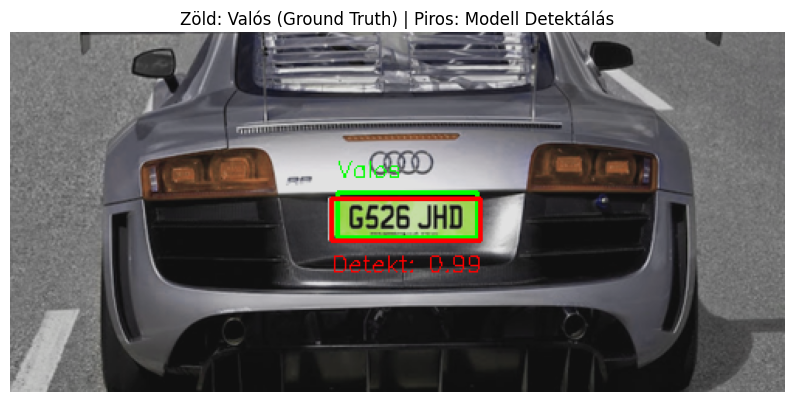

In [6]:
import torch
import numpy as np
from torch.utils.data import DataLoader, random_split
import time

# --- 1. SEGÉDFÜGGVÉNYEK ---

def collate_fn(batch):
    """
    Ez segít a DataLoadernek kezelni a különböző méretű képeket.
    Tuple-be rendezi őket ahelyett, hogy stackelné.
    """
    return tuple(zip(*batch))

def calculate_iou(boxA, boxB):
    """
    Kiszámolja az IoU-t (Átfedés mértéke) két doboz között.
    box: [xmin, ymin, xmax, ymax]
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# --- 2. ADATOK ELŐKÉSZÍTÉSE ÉS SZÉTVÁLASZTÁSA ---

# Útvonalak (ellenőrizd, hogy helyesek-e a Kaggle környezetben)
IMG_DIR = '/kaggle/input/car-plate-detection/images'
ANNOT_DIR = '/kaggle/input/car-plate-detection/annotations'

# Teljes adathalmaz betöltése
full_dataset = CarPlateDataset(IMG_DIR, ANNOT_DIR, transforms=get_transform(train=True))

# Szétválasztás: 80% Tanítás, 20% Teszt
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

print(f"Teljes adatmennyiség: {len(full_dataset)}")
print(f"Tanító halmaz: {len(train_dataset)} db")
print(f"Teszt halmaz: {len(test_dataset)} db")

# DataLoaderek létrehozása
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)

# --- 3. MODELL ÉS OPTIMALIZÁLÓ INICIALIZÁLÁSA ---

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f"Eszköz: {device}")

model = get_plate_detector_model(num_classes=2)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# --- 4. TANÍTÁSI CIKLUS (TRAINING LOOP) ---

num_epochs = 3

print("\n--- Tanítás indítása ---")
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    epoch_loss = 0
    
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    lr_scheduler.step()
    end_time = time.time()
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss/len(train_loader):.4f} | Idő: {end_time - start_time:.1f} sec")

print("Tanítás befejezve.")

# --- 5. KIÉRTÉKELÉS A TESZT ADATHALMAZON (EVALUATION) ---

print("\n--- Kiértékelés a Teszt halmazon ---")
model.eval()
ious = []
score_threshold = 0.5

with torch.no_grad():
    for images, targets in test_loader:
        images = list(img.to(device) for img in images)
        outputs = model(images)
        
        for i, output in enumerate(outputs):
            pred_boxes = output['boxes']
            pred_scores = output['scores']
            true_boxes = targets[i]['boxes'].to(device)
            
            # Csak a biztos találatokat vesszük figyelembe
            high_conf_indices = pred_scores > score_threshold
            pred_boxes = pred_boxes[high_conf_indices]
            
            if len(pred_boxes) > 0 and len(true_boxes) > 0:
                # Egyszerűsítés: vesszük a legbiztosabb predikciót és összevetjük az első valós dobozzal
                # (Komplexebb esetben minden dobozt minden dobozzal kéne párosítani)
                iou = calculate_iou(pred_boxes[0].cpu().numpy(), true_boxes[0].cpu().numpy())
                ious.append(iou)
            else:
                # Ha volt rendszám, de nem találtuk meg
                if len(true_boxes) > 0:
                    ious.append(0.0)

mean_iou = np.mean(ious) if ious else 0
print(f"\nÁtlagos IoU a teszt halmazon: {mean_iou:.4f}")
print(f"Ez azt jelenti, hogy átlagosan {mean_iou*100:.2f}%-ban fedi a detektált doboz a valódit.")

# --- 6. VIZUALIZÁCIÓ EGY TESZT KÉPEN ---
import cv2
import matplotlib.pyplot as plt

# Veszünk egy képet a teszt halmazból
img_tensor, target = test_dataset[0]
model.eval()
with torch.no_grad():
    prediction = model([img_tensor.to(device)])[0]

img_np = img_tensor.mul(255).permute(1, 2, 0).byte().numpy().copy()

# Valós doboz (Zöld)
for box in target['boxes']:
    cv2.rectangle(img_np, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
    cv2.putText(img_np, "Valos", (int(box[0]), int(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# Prediktált doboz (Piros)
for i, box in enumerate(prediction['boxes']):
    if prediction['scores'][i] > 0.5:
        cv2.rectangle(img_np, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)
        cv2.putText(img_np, f"Detekt: {prediction['scores'][i]:.2f}", (int(box[0]), int(box[3])+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

plt.figure(figsize=(10,10))
plt.imshow(img_np)
plt.title("Zöld: Valós (Ground Truth) | Piros: Modell Detektálás")
plt.axis('off')
plt.show()

Kiválasztott kép indexe: 32
Rendszám találat! Biztonság: 97.53%
Koordináták: (143, 110, 304, 149)


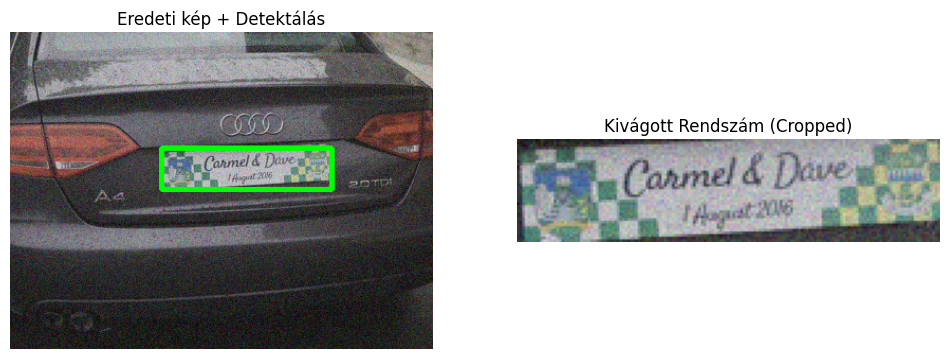

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

def extract_plate_from_image(image_tensor, model, device, threshold=0.6):
    """
    Kivágja a rendszámtáblát a detektált koordináták alapján.
    
    Args:
        image_tensor: A bemeneti kép (PyTorch Tensor)
        model: A betanított modell
        device: CPU vagy CUDA
        threshold: Csak ennél biztosabb találatokat fogad el
        
    Returns:
        cropped_image: A kivágott rendszám (NumPy array) vagy None, ha nincs találat
        box_coords: A koordináták (xmin, ymin, xmax, ymax)
    """
    # 1. Modell előkészítése
    model.eval()
    with torch.no_grad():
        # A modell listát vár, ezért []-be tesszük
        prediction = model([image_tensor.to(device)])[0]

    # 2. Eredmények feldolgozása
    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    
    # 3. A legjobb találat kiválasztása
    # Megkeressük a legnagyobb valószínűségű (score) dobozt
    if len(scores) > 0 and np.max(scores) > threshold:
        best_idx = np.argmax(scores) # A legmagasabb pontszám indexe
        best_box = boxes[best_idx]
        score = scores[best_idx]
        
        # Koordináták egésszé alakítása
        x_min, y_min, x_max, y_max = best_box.astype(int)
        
        # 4. Kép visszaalakítása Tensorból NumPy-ba a vágáshoz
        # (C, H, W) -> (H, W, C) és 0-255 skála
        full_image_np = image_tensor.mul(255).permute(1, 2, 0).byte().numpy()
        
        # Biztonsági ellenőrzés (ne vágjunk negatív indexszel)
        x_min, y_min = max(0, x_min), max(0, y_min)
        
        # 5. A tényleges kivágás (Slicing)
        # Fontos: numpy array-nél [sor, oszlop] -> [y, x] a sorrend!
        cropped_plate = full_image_np[y_min:y_max, x_min:x_max]
        
        return cropped_plate, (x_min, y_min, x_max, y_max), score
    
    return None, None, 0.0

# --- TESZTELÉS EGY VÉLETLENSZERŰ KÉPPEL ---

# Válasszunk egy képet a teszt halmazból
# (Használhatsz konkrét indexet is, pl: idx = 10)
import random
idx = random.randint(0, len(test_dataset)-1)
img_tensor, _ = test_dataset[idx]

print(f"Kiválasztott kép indexe: {idx}")

# FÜGGVÉNY HÍVÁSA
cropped_img, coords, conf = extract_plate_from_image(img_tensor, model, device)

# Eredmény megjelenítése
if cropped_img is not None:
    print(f"Rendszám találat! Biztonság: {conf:.2%}")
    print(f"Koordináták: {coords}")
    
    plt.figure(figsize=(12, 5))
    
    # Eredeti kép a kerettel
    full_img_np = img_tensor.mul(255).permute(1, 2, 0).byte().numpy().copy()
    cv2.rectangle(full_img_np, (coords[0], coords[1]), (coords[2], coords[3]), (0, 255, 0), 3)
    
    plt.subplot(1, 2, 1)
    plt.imshow(full_img_np)
    plt.title("Eredeti kép + Detektálás")
    plt.axis('off')
    
    # Kivágott rendszám
    plt.subplot(1, 2, 2)
    plt.imshow(cropped_img)
    plt.title("Kivágott Rendszám (Cropped)")
    plt.axis('off')
    
    plt.show()
    
    # Opcionális: A kivágott kép mentése fájlba
    # cv2.imwrite('kivagott_rendszam.jpg', cv2.cvtColor(cropped_img, cv2.COLOR_RGB2BGR))

else:
    print("Nem találtam rendszámot ezen a képen a megadott küszöbérték felett.")

--- Nyers OCR eredmények ---
Szöveg: Camel & Dave | Biztonság: 72.88%
Szöveg: Jaat% | Biztonság: 3.81%


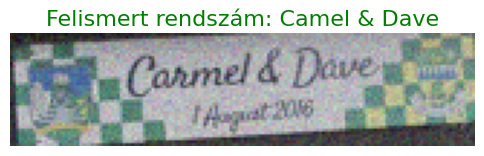

VÉGSŐ EREDMÉNY: Camel & Dave


In [8]:
import easyocr
import matplotlib.pyplot as plt

# 1. OCR Olvasó inicializálása
# 'en' (angol) nyelvet használunk, mert a rendszámok karakterei közösek az angollal.
# A gpu=True gyorsítja a folyamatot, ha van GPU.
reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())

def recognize_plate_text(image_np):
    """
    Kinyeri a szöveget a képről EasyOCR segítségével.
    """
    if image_np is None:
        return "Nincs kép"

    # A readtext függvény végzi a felismerést
    # detail=1: visszaadja a dobozt, a szöveget és a valószínűséget is
    results = reader.readtext(image_np, detail=1)
    
    detected_texts = []
    
    print("--- Nyers OCR eredmények ---")
    for (bbox, text, prob) in results:
        print(f"Szöveg: {text} | Biztonság: {prob:.2%}")
        
        # Csak akkor fogadjuk el, ha a biztonság 30% feletti (hogy a szemetet kiszűrjük)
        if prob > 0.3: 
            detected_texts.append(text)
            
    # Összefűzzük a talált szövegrészeket (pl. ha külön ismeri fel a régiókódot)
    final_text = "".join(detected_texts)
    
    # Tisztítás: eltávolítjuk a szóközöket és nem alfanumerikus karaktereket (opcionális)
    # final_text = ''.join(e for e in final_text if e.isalnum())
    
    return final_text

# --- FUTTATÁS A KORÁBBAN KIVÁGOTT KÉPEN ---

# Ellenőrizzük, hogy létezik-e a 'cropped_img' az előző lépésből
if 'cropped_img' in locals() and cropped_img is not None:
    
    # OCR futtatása
    plate_text = recognize_plate_text(cropped_img)
    
    # Eredmény megjelenítése
    plt.figure(figsize=(6, 4))
    plt.imshow(cropped_img)
    plt.axis('off')
    plt.title(f"Felismert rendszám: {plate_text}", fontsize=16, color='green')
    plt.show()
    
    print(f"VÉGSŐ EREDMÉNY: {plate_text}")
    
else:
    print("Hiba: A 'cropped_img' változó nem található vagy üres. Futtasd le előbb a kivágó kódot!")

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
import time
import cv2
import gc  # Garbage Collector

# --- 0. Clear GPU Memory ---
print("Clearing GPU memory...")
torch.cuda.empty_cache()
gc.collect()

# --- Configuration ---
NUM_FOLDS = 5
NUM_EPOCHS = 10
BATCH_SIZE = 3
NUM_CLASSES = 2  # Background + Plate
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# --- Re-Initialize Datasets (Fixes the AttributeError) ---
# We create two datasets: one with augmentation for training, one without for validation
# This ensures images are converted to Tensors (.to(DEVICE) will work)
dataset_train_full = CarPlateDataset(IMG_DIR, ANNOT_DIR, transforms=get_transform(train=True))
dataset_val_full = CarPlateDataset(IMG_DIR, ANNOT_DIR, transforms=get_transform(train=False))

# --- Helper Functions ---

def get_model_instance_segmentation(num_classes):
    # Load a pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def collate_fn(batch):
    return tuple(zip(*batch))

def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def evaluate_model(model, data_loader, device):
    model.eval()
    cpu_device = torch.device("cpu")
    total_true_positives = 0
    total_ground_truths = 0
    total_predictions = 0
    
    with torch.no_grad():
        for images, targets in data_loader:
            # This line caused the error previously; now fixed by dataset re-init
            images = list(img.to(device) for img in images)
            
            outputs = model(images)
            outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

            for target, output in zip(targets, outputs):
                gt_boxes = target['boxes'].numpy()
                pred_boxes = output['boxes'].numpy()
                pred_scores = output['scores'].numpy()
                
                # Confidence Threshold
                valid_indices = pred_scores > 0.5
                pred_boxes = pred_boxes[valid_indices]
                
                total_ground_truths += len(gt_boxes)
                total_predictions += len(pred_boxes)
                
                if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                    for p_box in pred_boxes:
                        ious = [calculate_iou(p_box, g_box) for g_box in gt_boxes]
                        if max(ious) >= 0.5: # IoU Threshold
                            total_true_positives += 1

    precision = total_true_positives / total_predictions if total_predictions > 0 else 0
    recall = total_true_positives / total_ground_truths if total_ground_truths > 0 else 0
    return precision, recall

# --- Main K-Fold Script ---

print(f"Starting {NUM_FOLDS}-Fold Cross Validation on {DEVICE}...")

# 1. Setup Data indices
dataset_indices = np.arange(len(dataset_train_full))
kfold = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

results = []

for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset_indices)):
    print(f"\n--- FOLD {fold + 1}/{NUM_FOLDS} ---")
    
    # 2. Create DataLoaders using the correct datasets (Train vs Val)
    train_subsampler = Subset(dataset_train_full, train_ids)
    val_subsampler = Subset(dataset_val_full, val_ids)
    
    data_loader_train = DataLoader(train_subsampler, batch_size=BATCH_SIZE, shuffle=True, 
                                   num_workers=2, collate_fn=collate_fn)
    data_loader_val = DataLoader(val_subsampler, batch_size=BATCH_SIZE, shuffle=False, 
                                 num_workers=2, collate_fn=collate_fn)
    
    # 3. Initialize Model
    model = get_model_instance_segmentation(NUM_CLASSES)
    model.to(DEVICE)
    
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # 4. Training Loop
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):
        model.train()
        epoch_loss = 0
        for images, targets in data_loader_train:
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            epoch_loss += losses.item()
        
        lr_scheduler.step()
        print(f"Fold {fold+1} Epoch {epoch+1} - Loss: {epoch_loss/len(data_loader_train):.4f}")

    training_time = time.time() - start_time
    
    # 5. Validation
    print(f"Validating Fold {fold+1}...")
    precision, recall = evaluate_model(model, data_loader_val, DEVICE)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # 6. Save Model
    model_name = f"model_fold_{fold+1}.pth"
    torch.save(model.state_dict(), model_name)
    
    # 7. Log Results
    results.append({
        'Fold': fold + 1,
        'Model Name': model_name,
        'Training Time (s)': round(training_time, 2),
        'Avg Loss': round(epoch_loss/len(data_loader_train), 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1 Score': round(f1_score, 4)
    })

# --- Create Excel Report ---
df_results = pd.DataFrame(results)
avg_row = df_results.mean(numeric_only=True)
avg_row['Model Name'] = 'AVERAGE'
df_results.loc['avg'] = avg_row

excel_filename = 'kfold_metrics.xlsx'
df_results.to_excel(excel_filename, index=False)

print(f"\nDone! Results saved to {excel_filename}")
print(df_results)

Clearing GPU memory...
Starting 5-Fold Cross Validation on cuda:0...

--- FOLD 1/5 ---
Fold 1 Epoch 1 - Loss: 0.1542
Fold 1 Epoch 2 - Loss: 0.0948
Fold 1 Epoch 3 - Loss: 0.0840
Fold 1 Epoch 4 - Loss: 0.0688
Fold 1 Epoch 5 - Loss: 0.0674
Fold 1 Epoch 6 - Loss: 0.0666
Fold 1 Epoch 7 - Loss: 0.0654
Fold 1 Epoch 8 - Loss: 0.0661
Fold 1 Epoch 9 - Loss: 0.0635
Fold 1 Epoch 10 - Loss: 0.0653
Validating Fold 1...

--- FOLD 2/5 ---
Fold 2 Epoch 1 - Loss: 0.1503
Fold 2 Epoch 2 - Loss: 0.0933
Fold 2 Epoch 3 - Loss: 0.0832
Fold 2 Epoch 4 - Loss: 0.0690
Fold 2 Epoch 5 - Loss: 0.0688
Fold 2 Epoch 6 - Loss: 0.0667
Fold 2 Epoch 7 - Loss: 0.0637
Fold 2 Epoch 8 - Loss: 0.0638
Fold 2 Epoch 9 - Loss: 0.0636
Fold 2 Epoch 10 - Loss: 0.0629
Validating Fold 2...

--- FOLD 3/5 ---
Fold 3 Epoch 1 - Loss: 0.1527
Fold 3 Epoch 2 - Loss: 0.0965
Fold 3 Epoch 3 - Loss: 0.0840
Fold 3 Epoch 4 - Loss: 0.0703
Fold 3 Epoch 5 - Loss: 0.0672
Fold 3 Epoch 6 - Loss: 0.0668
Fold 3 Epoch 7 - Loss: 0.0662
Fold 3 Epoch 8 - Loss: 